In [1]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Data can be downloaded from https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv?datasetId=855240&sortBy=voteCount \
Or use the cell bellow



In [8]:
# !pip install --upgrade --no-cache-dir gdown
# !gdown https://drive.google.com/uc?id=1RtaD_uBD0xrNI1qHKakkgchQWekz9RyP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1RtaD_uBD0xrNI1qHKakkgchQWekz9RyP
To: /content/archive.zip
100% 66.3M/66.3M [00:01<00:00, 38.5MB/s]


In [9]:
!unzip archive.zip 

Archive:  archive.zip
  inflating: age_gender.csv          


# Imports

In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import Dropout, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model
from livelossplot.tf_keras import PlotLossesCallback


# Prepeare data

In [11]:
IMAGE_SIZE = 48
CHECKPOINT_PATH = './checkpoints/'

In [12]:
!mkdir {CHECKPOINT_PATH}

mkdir: cannot create directory ‘./checkpoints/’: File exists


In [13]:
data = pd.read_csv('./age_gender.csv')

In [14]:
print(data.shape)
data.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [31]:
# Check missing data
data.isnull().sum()

age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

## Data distribution

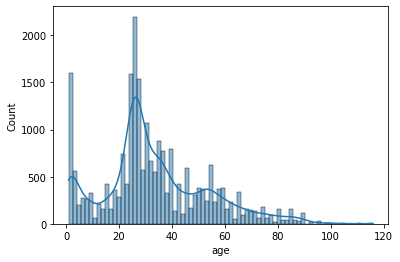

In [15]:
# Age distribution
sns.histplot(data.age, kde=True);

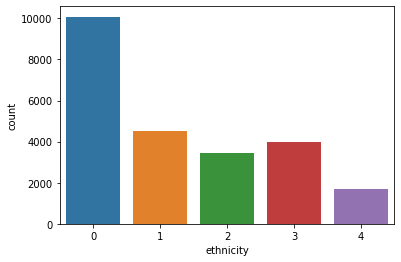

In [16]:
# Ethnicity distribution
sns.countplot(data=data, x='ethnicity');

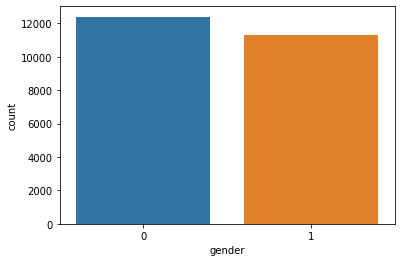

In [17]:
# Gender distribution
sns.countplot(data=data, x=data.gender);

Helper functions

In [18]:
def gen_np_image_from_pixels(pixels: str):
    np_img = np.array([int(i) for i in pixels.split()]) / 255.
    np_img = np_img.reshape((IMAGE_SIZE, IMAGE_SIZE, 1))
    return np_img

def plot_images(np_images, true_gender, true_ethnicity, true_age,
                pred_gender=None, pred_ethnicity=None, pred_age=None):
    plt.figure(figsize=(15, 15))
    for i in range(len(np_images)):
        if i > 15:
            break
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        pred_label = ''
        label = 'true| ' + \
                f'gender:{str(true_gender[i])[:3]} '+ \
                f'ethnicity:{true_ethnicity[i]} ' + \
                f'age:{int(true_age[i])}'
        if pred_gender is not None and pred_ethnicity is not None and pred_age is not None:
            pred_label = '\n predict| ' + \
                         f'gender:{int(pred_gender[i]>0.5)} '+ \
                         f'ethnicity:{pred_ethnicity[i]} ' + \
                         f'age:{int(pred_age[i])}'
        
        plt.xlabel(label+pred_label)
        plt.xlabel
        plt.imshow(np_images[i].reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')

In [19]:
X = [img for img in data['pixels'].apply(gen_np_image_from_pixels).values]
X = np.array(X)
y = data[['age', 'ethnicity', 'gender']].copy()

In [20]:
# discard emissions
y.age = y.age.apply(lambda x: 90 if x > 90 else x)

In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

print("Train data size:", X_train.shape[0])
print("Test data size:", X_test.shape[0])

Train data size: 17778
Test data size: 5927


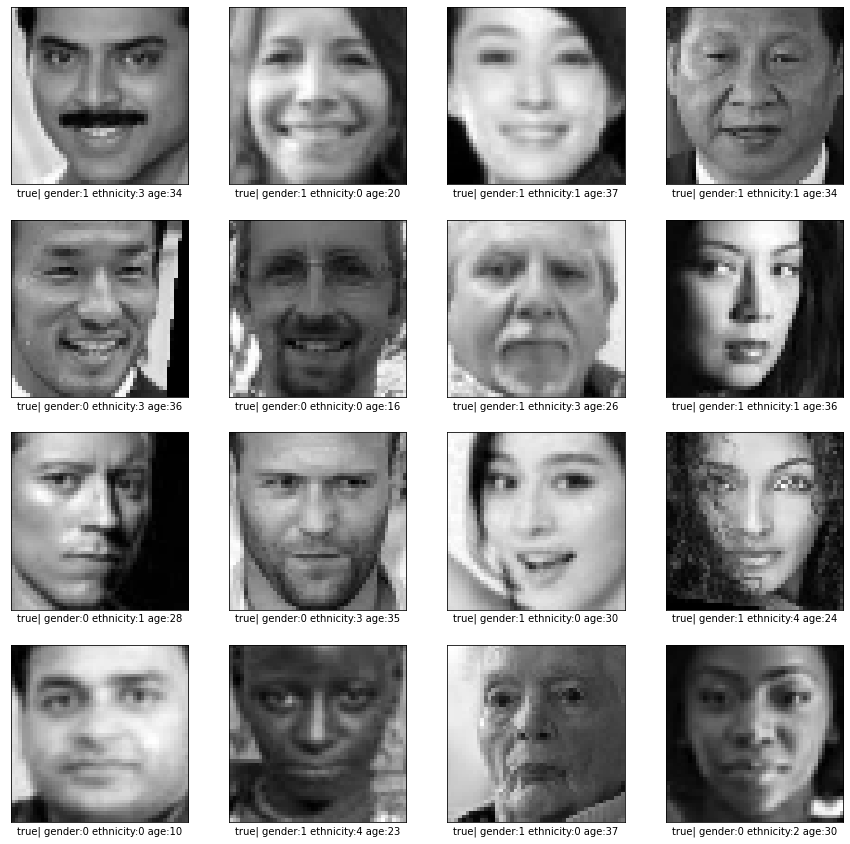

In [22]:
idxs = np.random.choice(X_train.shape[0], 16)
sample = X_train[idxs, ...]
gender = y.gender.values[idxs]
ethnicity = y.ethnicity.values[idxs]
age = y.age.values[idxs]
plot_images(sample, gender, ethnicity, age)

# Gender model

In [104]:
model_gender = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])
model_gender.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_69 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 flatten_29 (Flatten)        (None, 9216)              0         
                                                                 
 dense_58 (Dense)            (None, 64)              

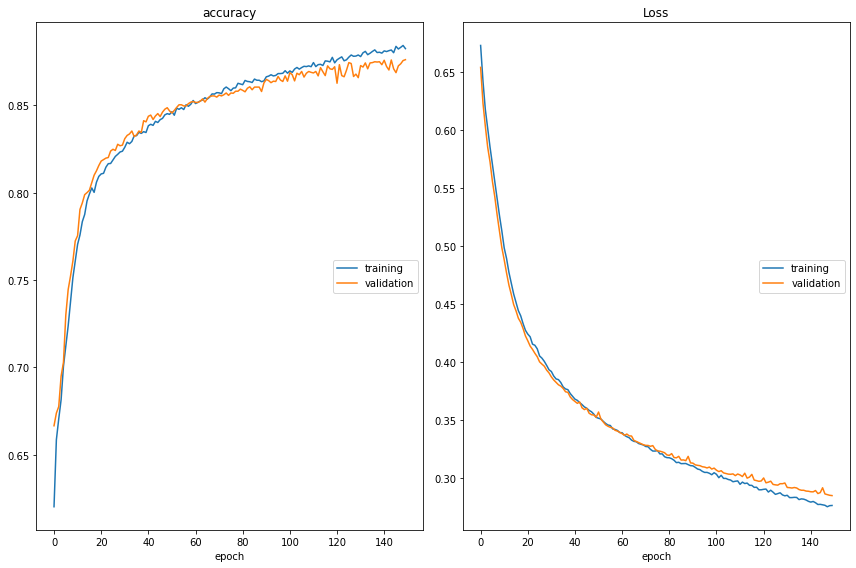

accuracy
	training         	 (min:    0.620, max:    0.884, cur:    0.882)
	validation       	 (min:    0.667, max:    0.876, cur:    0.876)
Loss
	training         	 (min:    0.275, max:    0.673, cur:    0.276)
	validation       	 (min:    0.285, max:    0.654, cur:    0.285)
139/139 [==============================] - 2s 15ms/step - loss: 0.2762 - accuracy: 0.8825 - val_loss: 0.2847 - val_accuracy: 0.8762


In [105]:
BATCH_SIZE = 128
EPOCHS = 150

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH + 'model_gender.h5',
                                               monitor='val_loss',
                                               mode='min',
                                               verbose=0,
                                               save_best_only=True,
                                               save_weights_only=False)

model_gender.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model_gender.fit(x=X_train, y=y_train.gender.values,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint_callback, PlotLossesCallback()],
                 validation_data=[X_test, y_test.gender.values])

In [106]:
model_gender = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_gender.h5')
loss, acc = model_gender.evaluate(X_test, y_test.gender.values)
print('Test loss:', loss)
print('Test accuracy:', acc)

186/186 [==============================] - 1s 3ms/step - loss: 0.2847 - accuracy: 0.8762
Test loss: 0.2847312390804291
Test accuracy: 0.8761599659919739


In [107]:
gender_predict_prob = model_gender.predict(X_test).ravel()
gender_predict = np.array([int(pred>0.5) for pred in gender_predict_prob])
gender_true = y_test.gender.values

186/186 [==============================] - 0s 2ms/step


In [108]:
def draw_roc_auc_curve(y_test, y_pred):
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    print('AUC-ROC score for gender classifcation:', roc_auc)
    plt.figure(figsize=(7, 7))
    plt.title('AUC-ROC Curve')
    plt.plot(fpr, tpr, label=f"auc {roc_auc}")
    plt.legend()
    plt.show()

Recall score for gender classification: 0.8604982206405694
Precision score for gender classification: 0.8760869565217392
F-score for gender classification: 0.8682226211849191
AUC-ROC score for gender classifcation: 0.9507691148414676


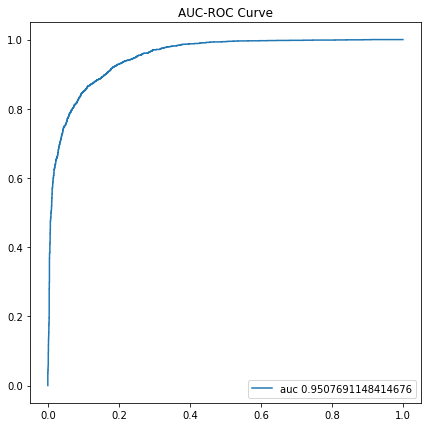

In [109]:
precision = precision_score(gender_true, gender_predict)
recall = recall_score(gender_true, gender_predict)
f_score = f1_score(gender_true, gender_predict)

print('Recall score for gender classification:', recall)
print('Precision score for gender classification:', precision)
print('F-score for gender classification:', f_score)
draw_roc_auc_curve(gender_true, gender_predict_prob)

# Ethnicity model

In [110]:
model_ethnicity = tf.keras.models.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
           input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_ethnicity.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 9216)              0         
                                                                 
 dense_60 (Dense)            (None, 64)              

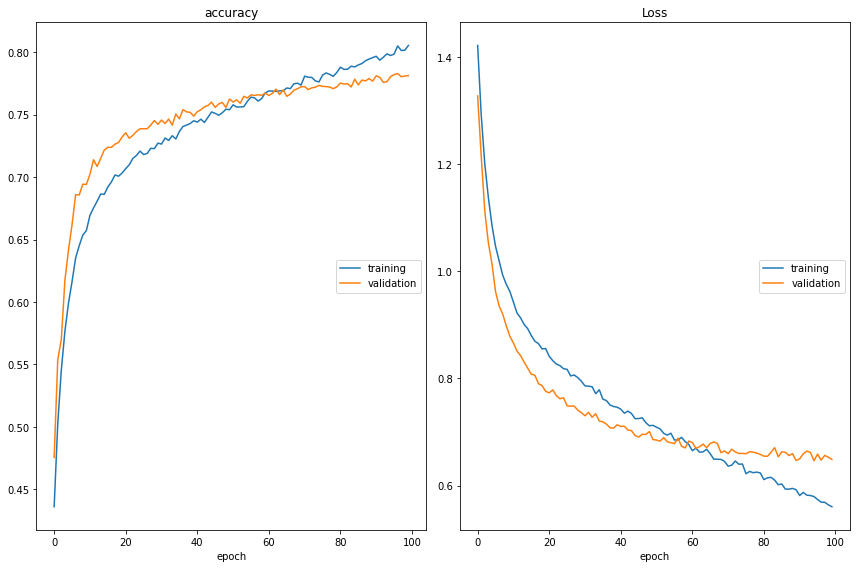

accuracy
	training         	 (min:    0.436, max:    0.805, cur:    0.805)
	validation       	 (min:    0.476, max:    0.783, cur:    0.781)
Loss
	training         	 (min:    0.560, max:    1.421, cur:    0.560)
	validation       	 (min:    0.646, max:    1.327, cur:    0.649)
139/139 [==============================] - 2s 14ms/step - loss: 0.5605 - accuracy: 0.8053 - val_loss: 0.6488 - val_accuracy: 0.7812


In [111]:
BATCH_SIZE = 128
EPOCHS = 100

loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'model_ethnicity.h5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               verbose=0,
                                                               save_best_only=True,
                                                               save_weights_only=False)

model_ethnicity.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model_ethnicity.fit(x=X_train, y=y_train.ethnicity.values,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=[X_test, y_test.ethnicity.values],
                    callbacks=[model_checkpoint_callback, PlotLossesCallback()])

In [112]:
model_ethnicity = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_ethnicity.h5')
loss, acc = model_ethnicity.evaluate(X_test, y_test.ethnicity.values, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.6463646292686462
Test accuracy: 0.780327320098877


In [113]:
ethnicity_predict_prob = model_ethnicity.predict(X_test, verbose=0)
ethnicity_predict = ethnicity_predict_prob.argmax(axis=1)
ethnicity_true = y_test.ethnicity.values

In [114]:
# Classes are not balanced, use macro
precision = precision_score(ethnicity_true, ethnicity_predict, average='macro')
recall = recall_score(ethnicity_true, ethnicity_predict, average='macro')
f_score = f1_score(ethnicity_true, ethnicity_predict, average='macro')
roc_auc = roc_auc_score(ethnicity_true, ethnicity_predict_prob, average='macro', multi_class='ovr')

print('Recall score for ethnicity classification:', recall)
print('Precision score for ethnicity classification:', precision)
print('F-score for ethnicity classification:', f_score)
print('AUC-ROC score for ethnicity classification:', roc_auc)

Recall score for ethnicity classification: 0.6591606826142311
Precision score for ethnicity classification: 0.7321271489125325
F-score for ethnicity classification: 0.6527144100772813
AUC-ROC score for ethnicity classification: 0.922442774444875


# Age model

In [115]:
model_age = tf.keras.models.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='relu')
])

model_age.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 6, 6, 128)      

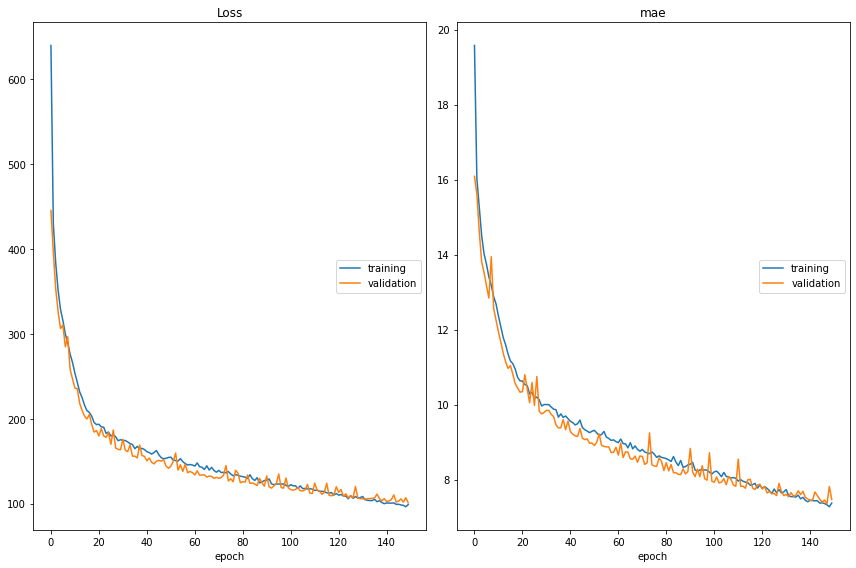

Loss
	training         	 (min:   96.396, max:  639.693, cur:   98.927)
	validation       	 (min:  100.977, max:  445.375, cur:  100.977)
mae
	training         	 (min:    7.277, max:   19.577, cur:    7.375)
	validation       	 (min:    7.356, max:   16.088, cur:    7.471)
139/139 [==============================] - 2s 17ms/step - loss: 98.9266 - mae: 7.3753 - val_loss: 100.9771 - val_mae: 7.4709


In [116]:
BATCH_SIZE = 128
EPOCHS = 150

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'model_age.h5',
                                                               monitor='val_loss',
                                                               mode='min',
                                                               verbose=0,
                                                               save_best_only=True,
                                                               save_weights_only=False)

model_age.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
model_age.fit(x=X_train, y=y_train.age.values,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=[X_test, y_test.age.values],
              callbacks=[model_checkpoint_callback, PlotLossesCallback()])

In [117]:
model_age = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_age.h5')
mse, mae = model_age.evaluate(X_test, y_test.age.values)

age_predict = model_age.predict(X_test, verbose=False).ravel()
age_true = y_test.age.values

R2 = r2_score(age_true, age_predict)

186/186 [==============================] - 1s 3ms/step - loss: 100.9771 - mae: 7.4709


In [118]:
print('MSE:', mse)
print('MAE:', mae)
print('R^2 score:', R2)

MSE: 100.9770736694336
MAE: 7.470880031585693
R^2 score: 0.74280300472764


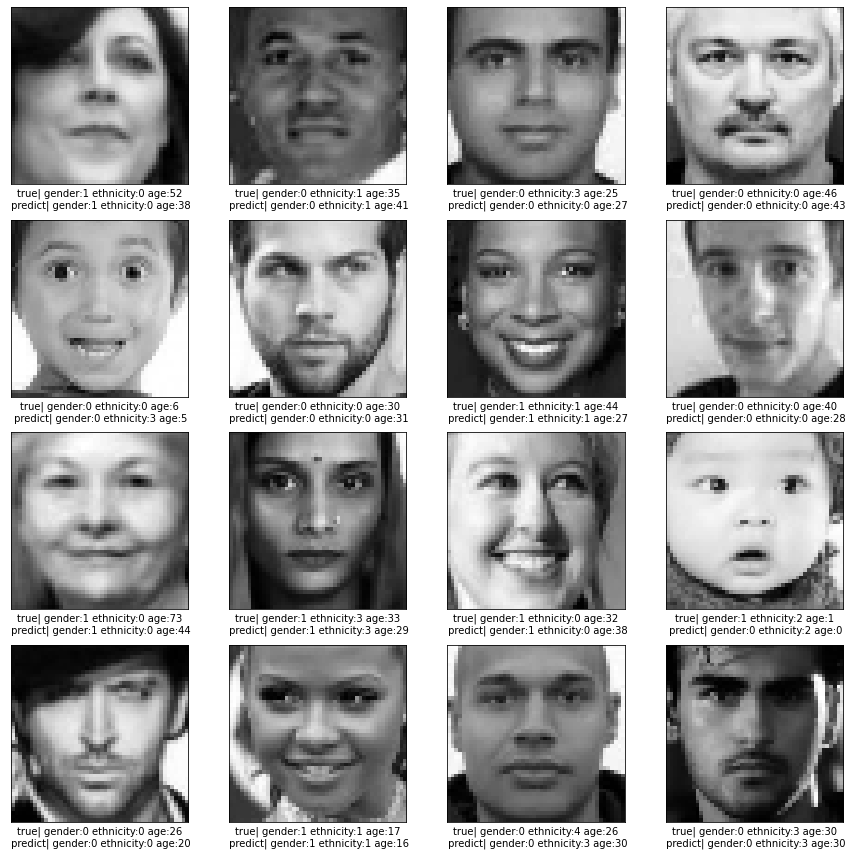

In [119]:
# predictions of all models
indxs = np.random.choice(X_test.shape[0], 16)
sample = X_test[indxs, ...]
ethnicity = model_ethnicity.predict(sample, verbose=0).argmax(axis=1)
gender = model_gender.predict(sample, verbose=0).ravel()
age = model_age.predict(sample, verbose=0).ravel()
true_values = y_test.iloc[indxs].values
plot_images(sample, true_values[:, 2], true_values[:, 1], true_values[:, 0],
            gender, ethnicity, age)

# Multitask learning

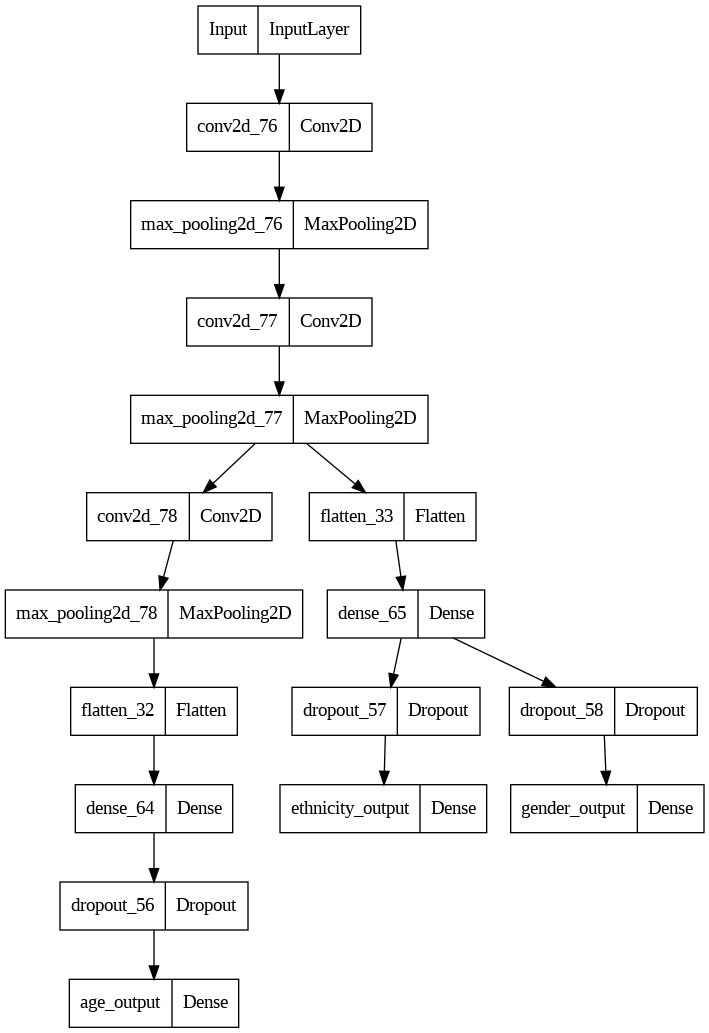

In [120]:
# Functional API
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='Input')
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

output_age = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
output_age = MaxPooling2D((2, 2))(output_age)
output_age = Flatten()(output_age)
output_age = Dense(128, activation='relu')(output_age)
output_age = Dropout(0.3)(output_age)
output_age = Dense(1, activation='relu', name='age_output')(output_age)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)

output_ethnicity = Dropout(0.5)(x)
output_ethnicity = Dense(5, activation='softmax', name='ethnicity_output')(output_ethnicity)

output_gender = Dropout(0.3)(x)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(output_gender)


model = tf.keras.Model(inputs=input_layer, outputs=[output_ethnicity, output_gender, output_age])

plot_model(model)

In [121]:
EPOCHS = 100
BATCH_SIZE = 128

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, 
              loss={'ethnicity_output': 'sparse_categorical_crossentropy',
                    'gender_output': 'binary_crossentropy',
                    'age_output': 'mse'},
              loss_weights={'ethnicity_output': 0.8, 'gender_output': 1., 'age_output': 0.001})

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_76 (Conv2D)             (None, 48, 48, 32)   320         ['Input[0][0]']                  
                                                                                                  
 max_pooling2d_76 (MaxPooling2D  (None, 24, 24, 32)  0           ['conv2d_76[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 24, 24, 64)   18496       ['max_pooling2d_76[0][0]']   

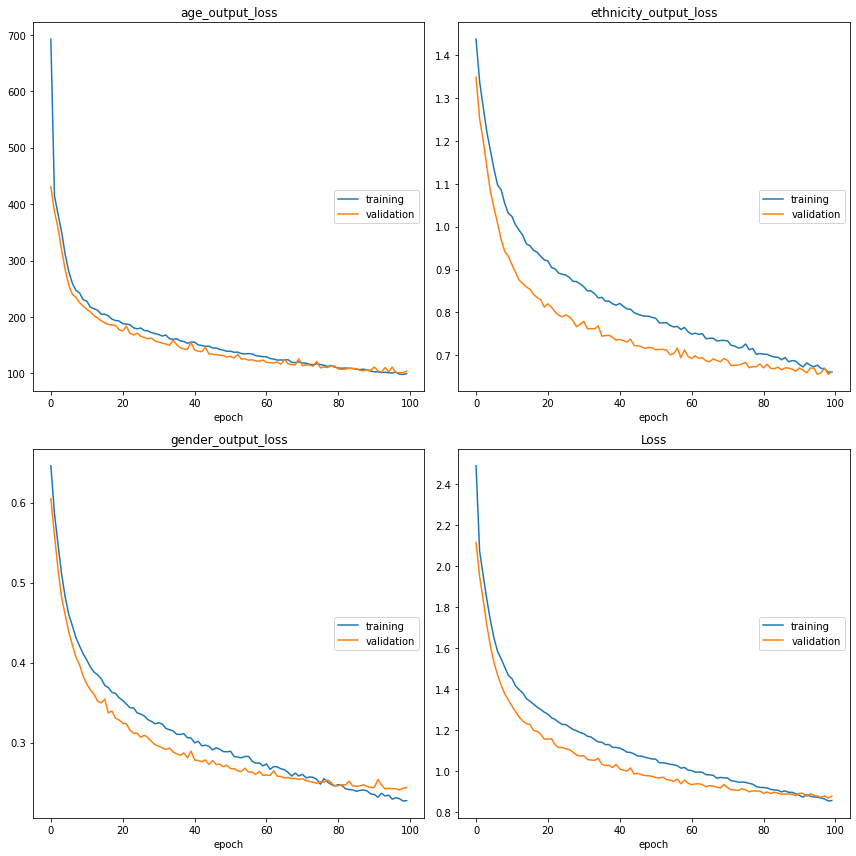

age_output_loss
	training         	 (min:   98.168, max:  692.150, cur:   99.669)
	validation       	 (min:  101.195, max:  430.980, cur:  104.220)
ethnicity_output_loss
	training         	 (min:    0.661, max:    1.437, cur:    0.661)
	validation       	 (min:    0.656, max:    1.348, cur:    0.662)
gender_output_loss
	training         	 (min:    0.227, max:    0.646, cur:    0.227)
	validation       	 (min:    0.241, max:    0.605, cur:    0.244)
Loss
	training         	 (min:    0.854, max:    2.488, cur:    0.856)
	validation       	 (min:    0.869, max:    2.115, cur:    0.878)
139/139 [==============================] - 3s 20ms/step - loss: 0.8561 - ethnicity_output_loss: 0.6613 - gender_output_loss: 0.2274 - age_output_loss: 99.6689 - val_loss: 0.8776 - val_ethnicity_output_loss: 0.6621 - val_gender_output_loss: 0.2438 - val_age_output_loss: 104.2200


In [122]:
callback1 = PlotLossesCallback()
callback2 = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH + 'model_func_api_best.h5',
                                              monitore='val_loss',
                                              mode='min',
                                              verbose=0,
                                              save_best_only=True,
                                              save_weights_only=False)

X_ = {'Input': X_train} 
y_ = {'ethnicity_output': y_train.ethnicity.values,
      'gender_output': y_train.gender.values,
      'age_output': y_train.age.values}
      
valid_data =  [{'Input': X_test}, 
               {'ethnicity_output': y_test.ethnicity.values,
                'gender_output': y_test.gender.values,
                'age_output': y_test.age.values}]
    
hist = model.fit(X_, y_,
                 validation_data = valid_data,
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 verbose=1,
                 callbacks=[callback1, callback2])

In [123]:
model = tf.keras.models.load_model(CHECKPOINT_PATH + 'model_func_api_best.h5')

In [124]:
_, ethnicity_loss, gender_loss, age_loss = \
    model.evaluate(X_test, [y_test.ethnicity.values, y_test.gender.values, y_test.age.values])
print('Ethnicity loss:', ethnicity_loss)
print('Gender loss:', gender_loss)
print('Age loss (MSE):', age_loss)

186/186 [==============================] - 1s 4ms/step - loss: 0.8687 - ethnicity_output_loss: 0.6558 - gender_output_loss: 0.2429 - age_output_loss: 101.1947
Ethnicity loss: 0.6558185815811157
Gender loss: 0.2428663969039917
Age loss (MSE): 101.1947250366211


In [125]:
predicts = model.predict(X_test)
ethnicity_prob = predicts[0]
ethnicity = ethnicity_prob.argmax(axis=1)
gender_prob = predicts[1].ravel()
gender = np.array([int(pred>0.5) for pred in gender_prob])
age = predicts[2].ravel()

186/186 [==============================] - 1s 2ms/step


Precision score for gender: 0.8889283179559971
Recall score for gender: 0.891459074733096
F-score for gender: 0.8901918976545842
AUC-ROC score for gender classifcation: 0.9643468774725218


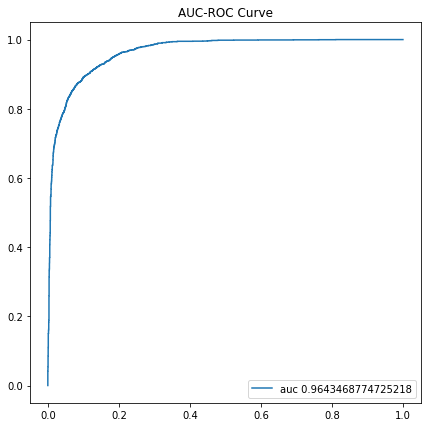

In [126]:
print('Precision score for gender:', precision_score(gender_true, gender))
print('Recall score for gender:', recall_score(gender_true, gender))
print('F-score for gender:', f1_score(gender_true, gender))
draw_roc_auc_curve(gender_true, gender_prob)

In [127]:
print('Precision score for ethnicity:', precision_score(ethnicity_true, ethnicity, average='macro'))
print('Recall score for ethnicity:', recall_score(ethnicity_true, ethnicity, average='macro'))
print('F-score for ethnicity:', f1_score(ethnicity_true, ethnicity, average='macro'))
print('AUC-ROC score for ethnicity:', 
      roc_auc_score(ethnicity_true, ethnicity_prob, average='macro', multi_class='ovr'))

Precision score for ethnicity: 0.6625354639263646
Recall score for ethnicity: 0.6557911343431548
F-score for ethnicity: 0.6389356000826536
AUC-ROC score for ethnicity: 0.9183236092203207


In [128]:
print('Age loss (MSE):', age_loss)
print('Age R^2 score:', r2_score(age_true, age))

Age loss (MSE): 101.1947250366211
Age R^2 score: 0.7422486297165617


Models individually show on the test data approximately the same results as the model created using the Functional API.

1/1 [==============================] - 0s 16ms/step


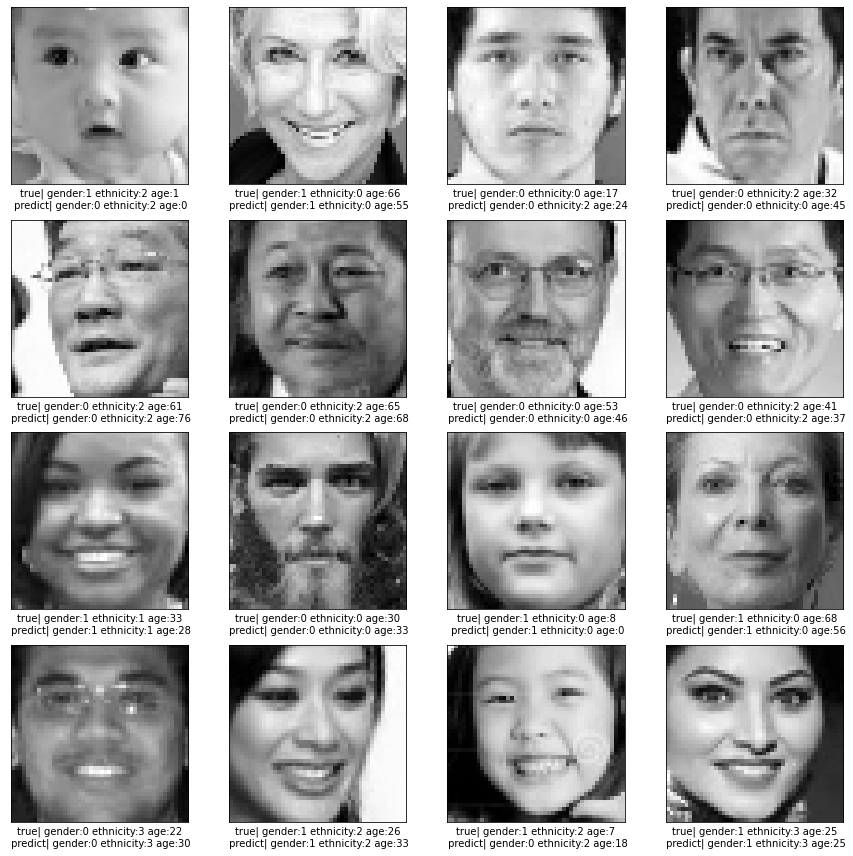

In [129]:
indxs = np.random.choice(len(X_test), 16)
sample = X_test[indxs, ...]
predicts = model.predict(sample)
ethnicity = predicts[0].argmax(axis=1)
gender = predicts[1].ravel()
age = predicts[2].ravel()
true_values = y_test.iloc[indxs].values
plot_images(sample, true_values[:, 2], true_values[:, 1], true_values[:, 0],
            gender, ethnicity, age)